# Tutorial 5: CCA on SST and SLP in Tropical Pacific (real data)

Here, we'll take the SST anomaly data from the last tutorial and add the same resolution gridded data of monthly mean sea level pressure over the dame domain (Tropical Pacific).  Period: Jan 1979 to July 2017

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [2]:
#load the SST anomalies (processed data from last tutorial)
xdata = pd.read_csv('SST_anomalies_data.csv')
months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [3]:
#now, load the SLP file (.nc) and process
filename = 'SLP_ERAInterim_monthly_Jan1979_Jul2017_Tropical_Pacific.nc'
dataERA = Dataset(filename)

lonERA = -360+dataERA.variables['longitude'][:] #in degrees E
latERA = dataERA.variables['latitude'][:] #in degrees N
timeERA = dataERA.variables['time'][:] #in hours since year 1900... not a great unit, but it's what ERA comes in
SLP = dataERA.variables['msl'] #in K

In [4]:
#reformat data from 3D to 2D, where rows are grid points, columns are months

SLP2d = np.empty((np.shape(SLP)[1]*np.shape(SLP)[2],np.shape(SLP)[0]))
for ii in range(np.shape(SLP)[0]):
    SLP2d[:,ii] = np.reshape(SLP[ii],(np.shape(SLP)[1]*np.shape(SLP)[2],))

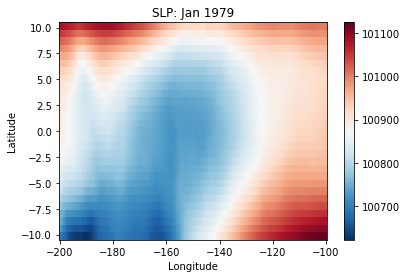

In [5]:
#plot SLP over whole domain Jan 1979

lonERAmin = np.min(lonERA)
lonERAmax = np.max(lonERA)
latERAmin = np.min(latERA)
latERAmax = np.max(latERA)
SLP_extent = [lonERAmin,lonERAmax,latERAmin,latERAmax]
plt.imshow(np.asarray(np.squeeze(SLP[0,:,:])), extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
plt.xlim(SLP_extent[:2])
plt.ylim(SLP_extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SLP: Jan 1979')
plt.colorbar()

plt.show()

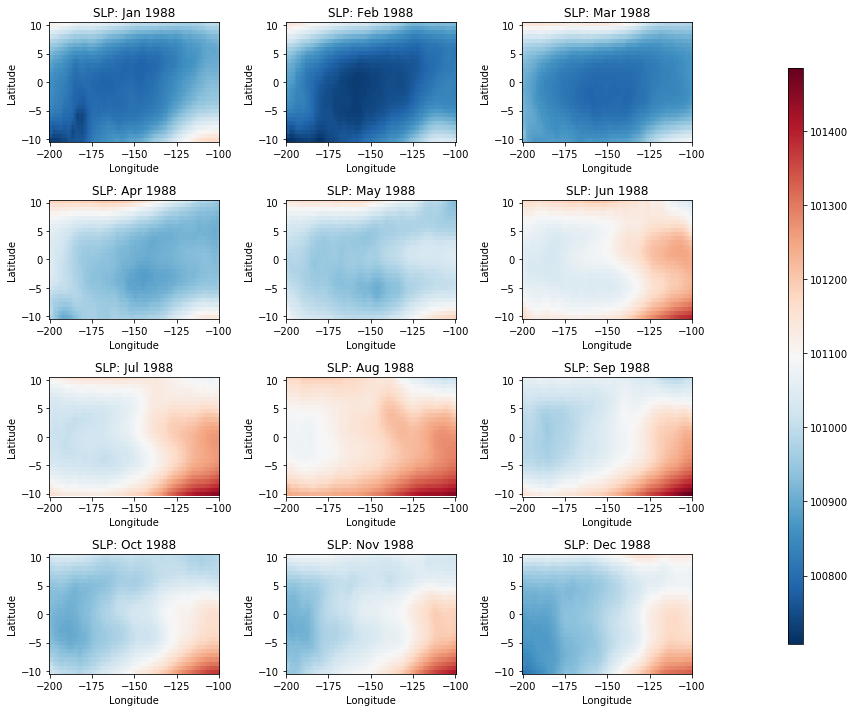

In [6]:
#plot SLP for each month in 1988, since this year had a strong La Nina event

vmin = np.min([SLP[12*9+month,:,:] for month in range(12)])
vmax = np.max([SLP[12*9+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(SLP[12*9+month,:,:])), extent=SLP_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.set_xlim(SLP_extent[:2])
    ax.set_ylim(SLP_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('SLP: ' + months[month] +' 1988')
    #plt.colorbar()
    month+=1
 
plt.tight_layout()
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

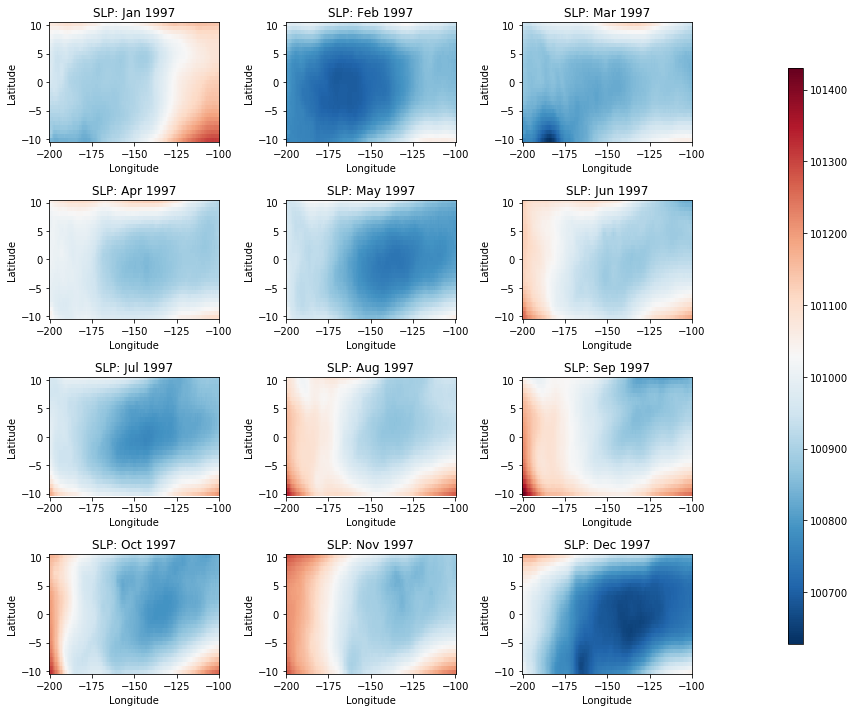

In [7]:
#plot SLP for each month in 1997, since this year had a strong El Nino event

vmin = np.min([SLP[12*18+month,:,:] for month in range(12)])
vmax = np.max([SLP[12*18+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(SLP[12*18+month,:,:])), extent=SLP_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.set_xlim(SLP_extent[:2])
    ax.set_ylim(SLP_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('SLP: ' + months[month] +' 1997')
    #plt.colorbar()
    month+=1
    
plt.tight_layout()    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

Preprocessing: remove seasonal cycle and apply 3-month running mean -- we want smoothed anomalies!

In [8]:
#remove last 7 months from 2017, so the timeseries line up
SLP_cut = SLP[:-7]
SLP2d_cut = SLP2d[:,:-7]

#calculate seasonal signal for each grid point
nyears = 38
SLP2d_seasonal = np.empty((np.shape(SLP2d)[0],12))
for ii in range(len(SLP2d_cut)):
    SLP2d_seasonal[ii,:] = np.mean(np.reshape(SLP2d_cut[ii,:],(nyears,12)),axis=0)

#repeat the seasonal cycle for all years
SLP2d_seasonal_all = np.tile(SLP2d_seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
SLP2d_anomalies = SLP2d_cut - SLP2d_seasonal_all

#apply 3-month running mean on each grid point 
SLP2d_anomalies_smooth = np.empty_like(SLP2d_anomalies)
N=3 #length of moving window
for ii in range(len(SLP2d_anomalies)):
    x=SLP2d_anomalies[ii,:]
    SLP2d_anomalies_smooth[ii,:] = np.convolve(x, np.ones((N,))/N, mode='same')


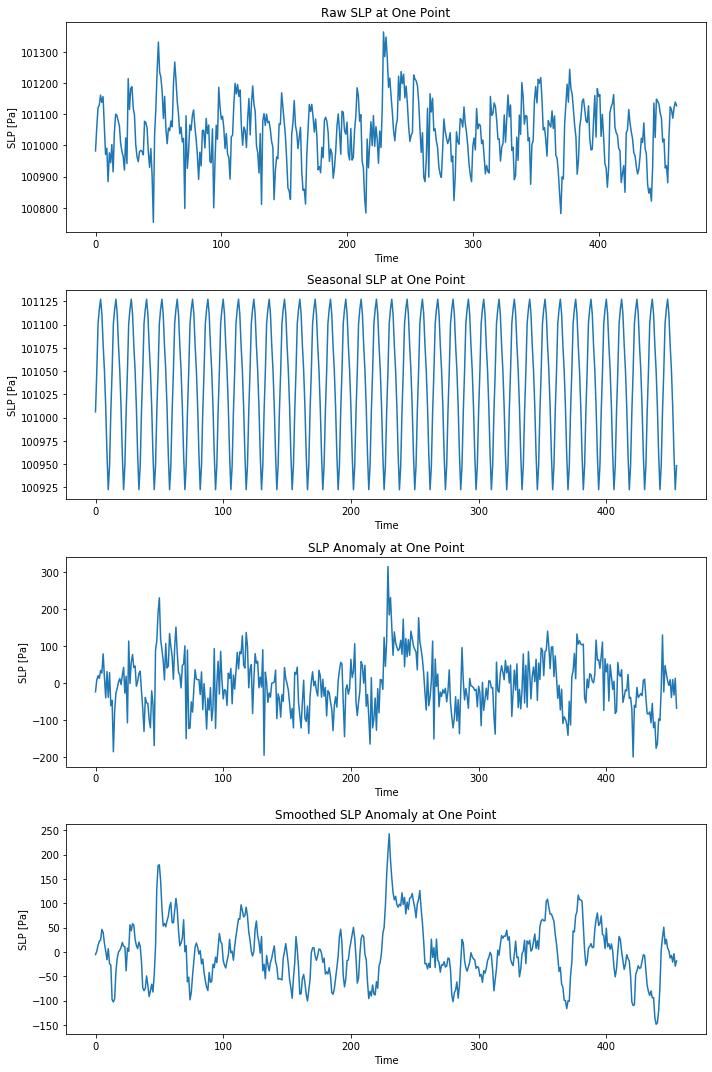

In [9]:
#let's visualize all of these great pre-processing steps!

gridIndex = 50 #arbitrary grid point to visualize the preprocessing for

plt.figure(figsize=(10,15))

plt.subplot(4,1,1)
plt.plot(SLP2d[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('SLP [Pa]')
plt.title('Raw SLP at One Point')

plt.subplot(4,1,2)
plt.plot(SLP2d_seasonal_all[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('SLP [Pa]')
plt.title('Seasonal SLP at One Point')

plt.subplot(4,1,3)
plt.plot(SLP2d_anomalies[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('SLP [Pa]')
plt.title('SLP Anomaly at One Point')

plt.subplot(4,1,4)
plt.plot(SLP2d_anomalies_smooth[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('SLP [Pa]')
plt.title('Smoothed SLP Anomaly at One Point')

plt.tight_layout()
plt.show()

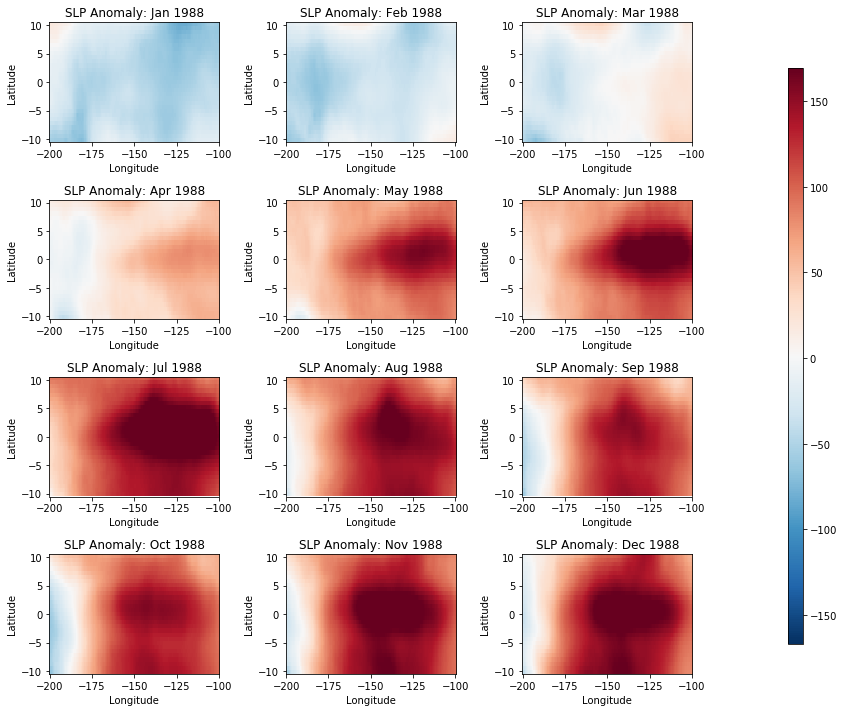

In [10]:
#plot the 3-month running mean of residuals for all grid points for all months of 1988

vmin = np.min([SLP2d_anomalies_smooth[12*9+month,:] for month in range(12)])
vmax = np.max([SLP2d_anomalies_smooth[12*9+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.reshape(SLP2d_anomalies_smooth[:,12*9+month],(29,135))), extent=SLP_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.set_xlim(SLP_extent[:2])
    ax.set_ylim(SLP_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('SLP Anomaly: ' + months[month] +' 1988')
    month+=1
    
plt.tight_layout()   
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

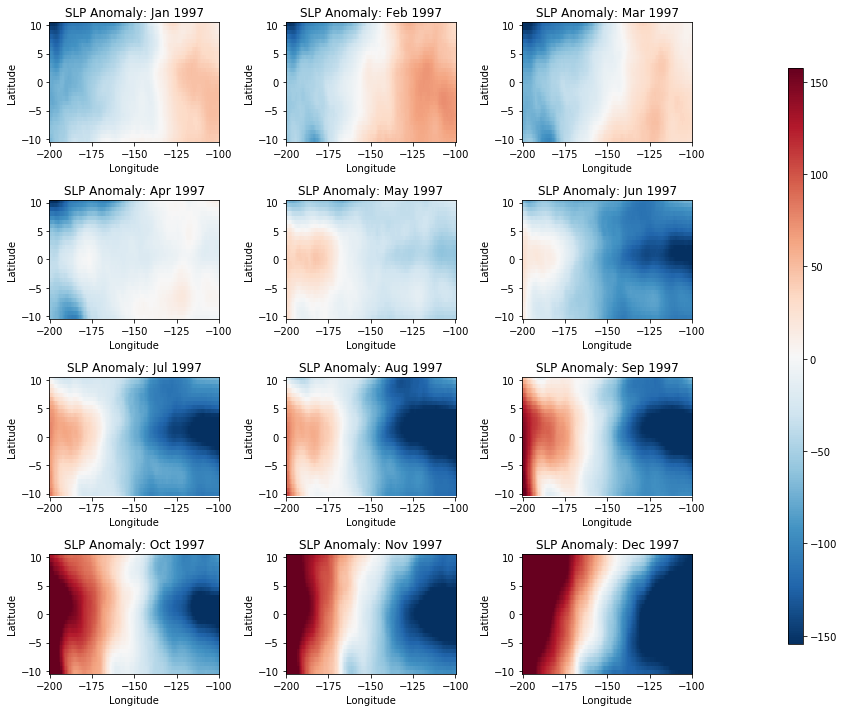

In [11]:
#plot the 3-month running mean of residuals for all grid points for all months of 1997

vmin = np.min([SLP2d_anomalies_smooth[12*18+month,:] for month in range(12)])
vmax = np.max([SLP2d_anomalies_smooth[12*18+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    im = ax.imshow(np.asarray(np.reshape(SLP2d_anomalies_smooth[:,12*18+month],(29,135))), extent=SLP_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.set_xlim(SLP_extent[:2])
    ax.set_ylim(SLP_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('SLP Anomaly: ' + months[month] +' 1997')
    #plt.colorbar()
    month+=1

plt.tight_layout()
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)

In [12]:
#make sure xdata and ydata are the right shapes

xdata = xdata[:-3]
ydata =SLP2d_anomalies_smooth.T

print('xdata: ' + str(np.shape(xdata)[0]) + ' rows, ' + str(np.shape(xdata)[1]) + ' columns')
print('ydata: ' + str(np.shape(ydata)[0]) + ' rows, ' + str(np.shape(ydata)[1]) + ' columns')

xdata: 456 rows, 3915 columns
ydata: 456 rows, 3915 columns


In [13]:
#do CCA
n_modes = 3 #modes to keep
cca = CCA(n_components=n_modes,max_iter = 10000)
U,V = cca.fit_transform(xdata,ydata)
A = cca.x_weights_
B = cca.y_weights_
F = np.cov(xdata.T)@A
G = np.cov(ydata.T)@B
r = [np.corrcoef(U[:,ii],V[:,ii]) for ii in range(n_modes)]

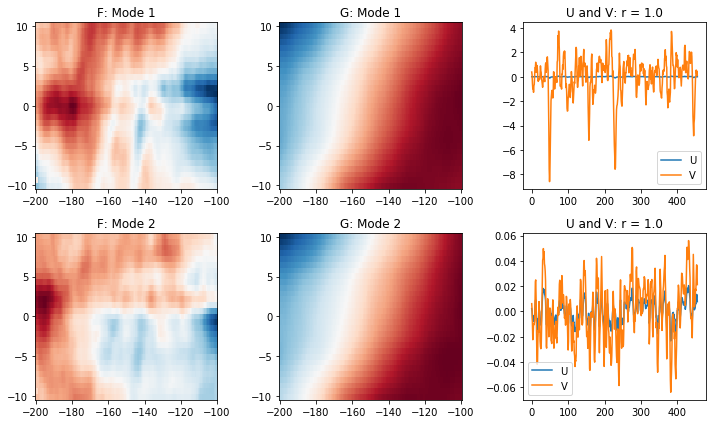

In [14]:
#visualize results of first n modes

n = 2

plt.figure(figsize=(10,6))

for kk in range(n):
    
    plt.subplot(n,3,kk*3+1)
    plt.imshow(np.reshape(F[:,kk],(29,135)),extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
    plt.title('F: Mode ' + str(kk+1))
    
    plt.subplot(n,3,kk*3+2)
    plt.imshow(np.reshape(G[:,kk],(29,135)),extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
    plt.title('G: Mode ' + str(kk+1))
    
    plt.subplot(n,3,kk*3+3)
    plt.plot(U[:,kk])
    plt.plot(V[:,kk])
    plt.title('U and V: r = ' + str(r[kk][0][1]))
    plt.legend(['U','V'])
    
plt.tight_layout()
plt.show()

Perfectly correlated modes indicates that we're finding modes that likely do not explain much variance -- just finding noise.  The solution to this problem is to perform PCA on each of xdata and ydata separately first, then reconstruct using the main modes, then perform CCA on this reconstructed data.

In [15]:
#do PCA on T and SST datasets so that CCA is finding modes which explain non-negligible fractions of total variance

pca_input_SST = xdata
n_modes_SST = np.min(np.shape(xdata))
pca_SST = PCA(n_components = n_modes_SST)
PCs_SST = pca_SST.fit_transform(pca_input_SST)
eigvecs_SST = pca_SST.components_
fracVar_SST = pca_SST.explained_variance_ratio_

pca_input_SLP = ydata
n_modes_SLP = np.min(np.shape(ydata))
pca_SLP = PCA(n_components = n_modes_SLP)
PCs_SLP = pca_SLP.fit_transform(pca_input_SLP)
eigvecs_SLP = pca_SLP.components_
fracVar_SLP = pca_SLP.explained_variance_ratio_

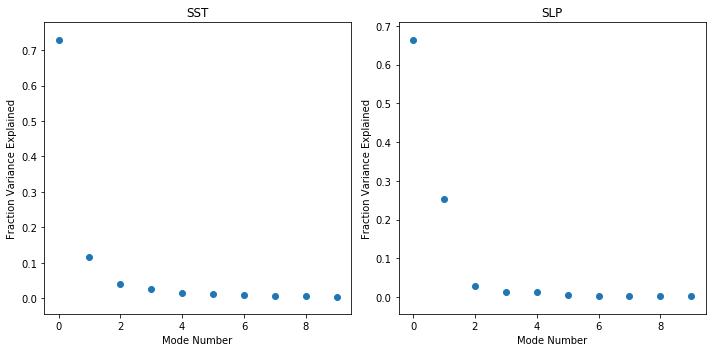

In [16]:
#plot fraction of variance explained by modes of SST and SLP to choose how many modes to use in reconstruction

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar_SST[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('SST')

plt.subplot(1,2,2)
plt.scatter(range(n_modes_show),fracVar_SLP[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('SLP')

plt.tight_layout()

plt.show()

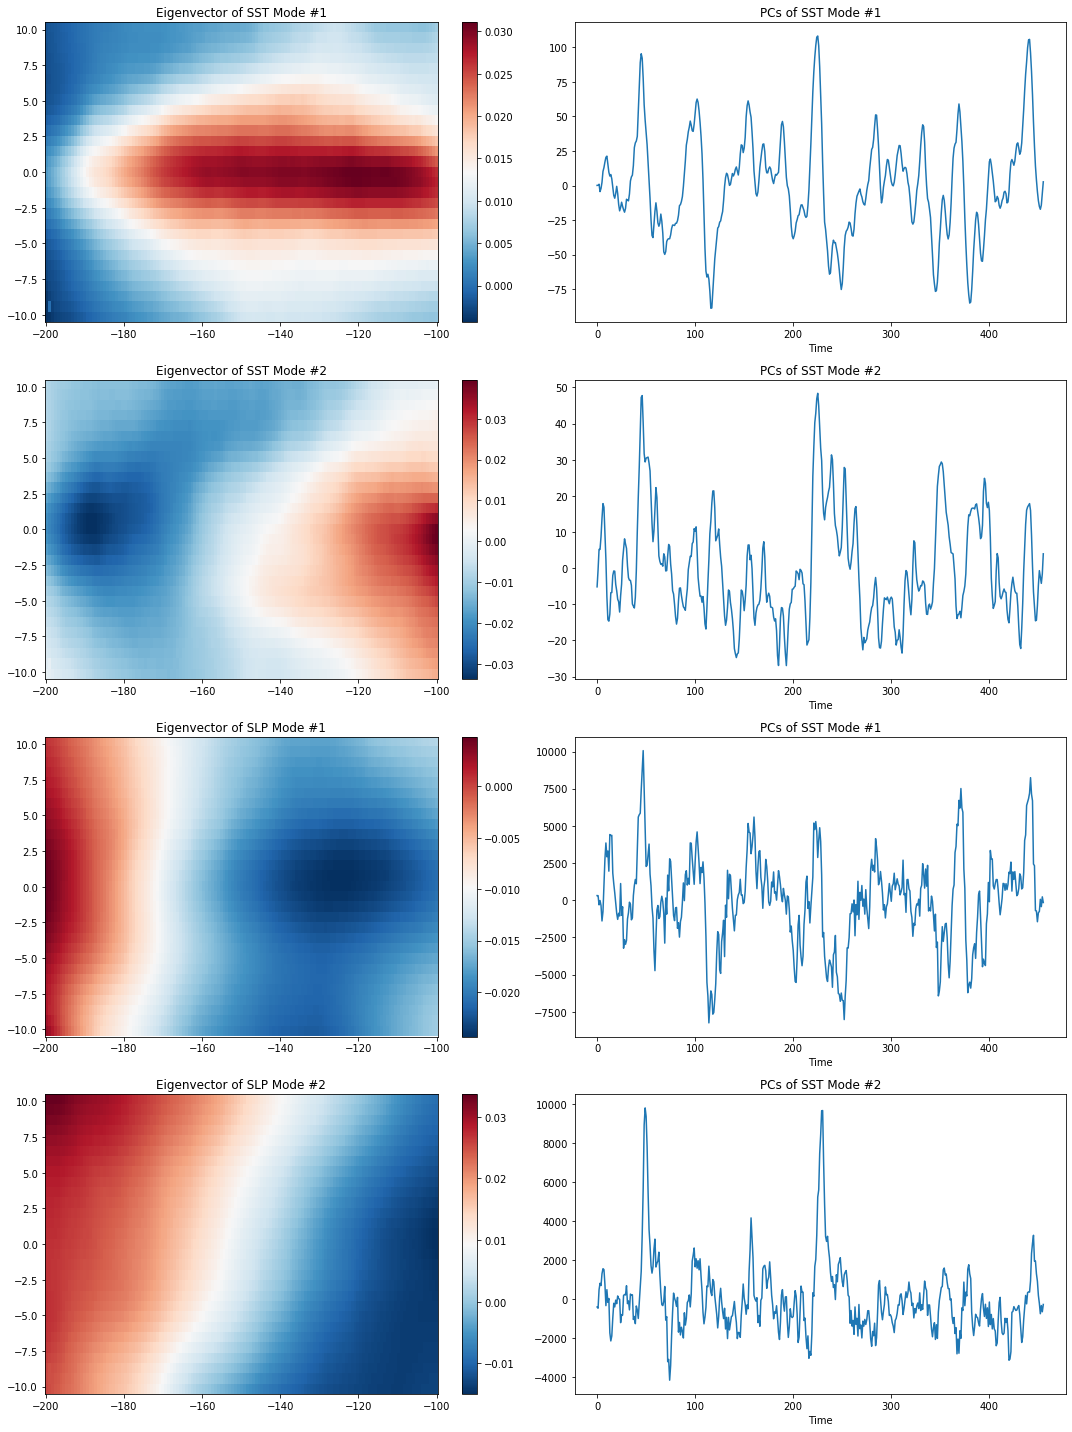

In [17]:
#visualize PCA modes

n = 2

plt.figure(figsize=(15,10*n))
for kk in range(n):
    
    plt.subplot(2*n,2,kk*2+1)
    plt.imshow(np.reshape(eigvecs_SST[kk,:],(29,135)),extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
    plt.xlim(SLP_extent[:2])
    plt.ylim(SLP_extent[2:])
    plt.title('Eigenvector of SST Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(2*n,2,(kk+1)*2)
    plt.plot(PCs_SST[:,kk])
    plt.title('PCs of SST Mode #' + str(kk+1))
    plt.xlabel('Time')
    
    plt.subplot(2*n,2,kk*2+5)
    plt.imshow(np.reshape(eigvecs_SLP[kk,:],(29,135)),extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
    plt.title('Eigenvector of SLP Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(2*n,2,kk*2+6)
    plt.plot(PCs_SLP[:,kk])
    plt.title('PCs of SST Mode #' + str(kk+1))
    plt.xlabel('Time')
    
    plt.tight_layout()

In [18]:
#reconstruct SST and SLP, using first two modes for each dataset

n_modes_SST = 2
numObs = np.shape(pca_input_SST)[0]
xdata_rec = np.empty_like(pca_input_SST)
for kk in range(numObs): #for each month
    this_xdata_rec = np.zeros_like(xdata.get_values()[0])
    for mode in range(n_modes_SST):
        this_xdata_rec += eigvecs_SST[mode,:]*PCs_SST[kk,mode]    
    xdata_rec[kk,:] = this_xdata_rec
    
n_modes_SLP = 2
numObs = np.shape(pca_input_SLP)[0]
ydata_rec = np.empty_like(pca_input_SLP)
for kk in range(numObs): #for each month
    this_ydata_rec = np.zeros_like(ydata[0])
    for mode in range(n_modes_SST):
        this_ydata_rec += eigvecs_SLP[mode,:]*PCs_SLP[kk,mode]    
    ydata_rec[kk,:] = this_ydata_rec

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  import sys


In [19]:
#do CCA
n_modes = 3 #modes to keep
cca = CCA(n_components=n_modes,max_iter = 10000)
U,V = cca.fit_transform(xdata_rec,ydata_rec)
A = cca.x_weights_
B = cca.y_weights_
F = np.cov(xdata.T)@A
G = np.cov(ydata.T)@B
r = [np.corrcoef(U[:,ii],V[:,ii]) for ii in range(n_modes)]

/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


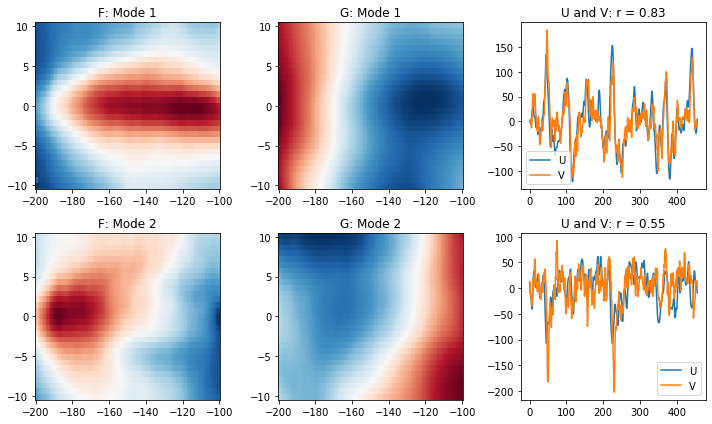

In [20]:
#visualize results of first n modes

n = 2

plt.figure(figsize=(10,6))

for kk in range(n):
    
    plt.subplot(n,3,kk*3+1)
    plt.imshow(np.reshape(F[:,kk],(29,135)),extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
    plt.title('F: Mode ' + str(kk+1))
    
    plt.subplot(n,3,kk*3+2)
    plt.imshow(np.reshape(G[:,kk],(29,135)),extent=SLP_extent,cmap = 'RdBu_r',aspect='auto')
    plt.title('G: Mode ' + str(kk+1))
    
    plt.subplot(n,3,kk*3+3)
    plt.plot(U[:,kk])
    plt.plot(V[:,kk])
    plt.title('U and V: r = ' + str(r[kk][0][1])[:4])
    plt.legend(['U','V'])
    
plt.tight_layout()
plt.show()